In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,  GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

C:\Users\Acer\anaconda3\anaconda\envs\tensorflow_env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# ! pip install kagglehub

In [3]:
# ! pip install streamlit

## Downloading Dataset

In [4]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

# print("Path to dataset files:", path)

In [5]:
BASE_DIR = Path('images')  # Update this to your data directory
TRAIN_DIR = BASE_DIR / 'train'
VALID_DIR = BASE_DIR / 'validation'
SAMPLE_DIR = BASE_DIR / 'sample'

# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 32

print(f"Train directory exists: {TRAIN_DIR.exists()}")
print(f"Valid directory exists: {VALID_DIR.exists()}")
print(f"Sample directory exists: {SAMPLE_DIR.exists()}")

Train directory exists: True
Valid directory exists: True
Sample directory exists: True


In [6]:
# Count images in each set
def count_images(directory):
    """Count total images and images per class in a directory."""
    total = 0
    class_counts = {}
    
    for class_dir in sorted(directory.iterdir()):
        if class_dir.is_dir():
            num_images = len(list(class_dir.glob('*.jpg')))
            class_counts[class_dir.name] = num_images
            total += num_images
    
    return total, class_counts

# Count images in each set
train_total, train_counts = count_images(TRAIN_DIR)
valid_total, valid_counts = count_images(VALID_DIR)
sample_total = len(os.listdir(SAMPLE_DIR))

print(f"Training images: {train_total}")
print(f"Validation images: {valid_total}")
print(f"Sample images: {sample_total}")
print(f"\nNumber of classes (emotions): {len(train_counts)}")
print(f"\nAll 7 Emotions: {list(train_counts.keys())[:10]}")

Training images: 28821
Validation images: 7066
Sample images: 8

Number of classes (emotions): 7

All 7 Emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [7]:
train_happy = len(os.listdir(os.path.join(TRAIN_DIR, 'happy')))
train_sad = len(os.listdir(os.path.join(TRAIN_DIR, 'sad')))
train_fear = len(os.listdir(os.path.join(TRAIN_DIR, 'fear')))
train_disgust = len(os.listdir(os.path.join(TRAIN_DIR, 'disgust')))
train_angry = len(os.listdir(os.path.join(TRAIN_DIR, 'angry')))
train_neutral = len(os.listdir(os.path.join(TRAIN_DIR, 'neutral')))
train_surprise = len(os.listdir(os.path.join(TRAIN_DIR, 'surprise')))

print(f"Training happy: {train_happy} images")
print(f"Training sad: {train_sad} images")
print(f"Training fear: {train_fear} images")
print(f"Training disgust: {train_disgust} images")
print(f"Training angry: {train_angry} images")
print(f"Training neutral: {train_neutral} images")
print(f"Training surprise: {train_surprise} images")
print(f"Total training images: {train_happy + train_sad + train_fear + train_disgust + train_angry + train_neutral + train_surprise}")
# print(f"Total training images: {count_images(TRAIN_DIR)}")


Training happy: 7164 images
Training sad: 4938 images
Training fear: 4103 images
Training disgust: 436 images
Training angry: 3993 images
Training neutral: 4982 images
Training surprise: 3205 images
Total training images: 28821


In [8]:
valid_happy = len(os.listdir(os.path.join(VALID_DIR, 'happy')))
valid_sad = len(os.listdir(os.path.join(VALID_DIR, 'sad')))
valid_fear = len(os.listdir(os.path.join(VALID_DIR, 'fear')))
valid_disgust = len(os.listdir(os.path.join(VALID_DIR, 'disgust')))
valid_angry = len(os.listdir(os.path.join(VALID_DIR, 'angry')))
valid_neutral = len(os.listdir(os.path.join(VALID_DIR, 'neutral')))
valid_surprise = len(os.listdir(os.path.join(VALID_DIR, 'surprise')))

print(f"Validation happy: {valid_happy} images")
print(f"Validation sad: {valid_sad} images")
print(f"Validation fear: {valid_fear} images")
print(f"Validation disgust: {valid_disgust} images")
print(f"Validation angry: {valid_angry} images")
print(f"Validation neutral: {valid_neutral} images")
print(f"Validation surprise: {valid_surprise} images")
print(f"Total validation images: {valid_happy + valid_sad + valid_fear + valid_disgust + valid_angry + valid_neutral + valid_surprise}")
# print(f"Total validing images: {count_images(TRAIN_DIR)}")


Validation happy: 1825 images
Validation sad: 1139 images
Validation fear: 1018 images
Validation disgust: 111 images
Validation angry: 960 images
Validation neutral: 1216 images
Validation surprise: 797 images
Total validation images: 7066


## Visualisations

In [9]:
df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
df.sort_values(by='Count', ascending=False).head()

,Class,Count
3,happy,7164
4,neutral,4982
5,sad,4938
2,fear,4103
0,angry,3993


In [10]:
df.describe()

,Count
count,7.000000
mean,4117.285714
std,2045.464553
min,436.000000
25%,3599.000000
50%,4103.000000
75%,4960.000000
max,7164.000000


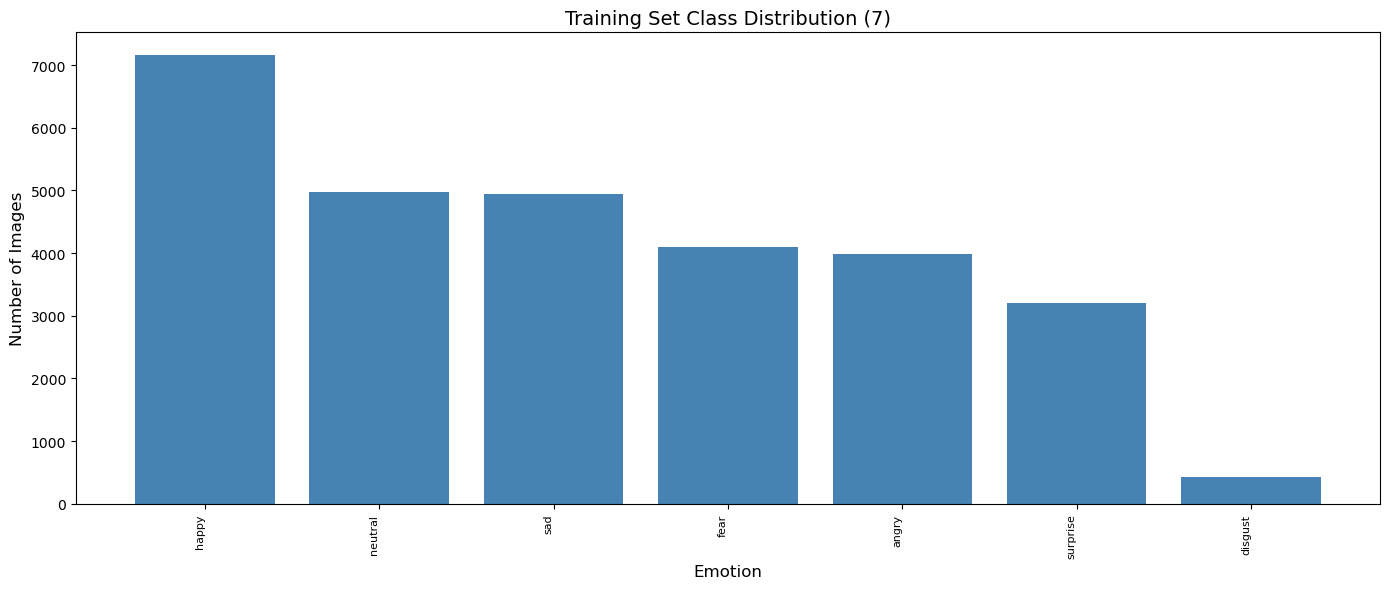

Mean images per class: 4117.29
Std images per class: 2045.46
Min images per class: 436
Max images per class: 7164


In [11]:
# Visualize class distribution
def plot_class_distribution(class_counts, title="Class Distribution", n=7):
    """Plot class distribution as a bar chart."""
    df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
    df = df.sort_values('Count', ascending=False).head(n)
    
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(df)), df['Count'], color='steelblue')
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.title(f'{title} ({n})', fontsize=14)
    plt.xticks(range(len(df)), df['Class'], rotation=90, ha='right', fontsize=8)
    plt.tight_layout()
    plt.show()
    
    print(f"Mean images per class: {df['Count'].mean():.2f}")
    print(f"Std images per class: {df['Count'].std():.2f}")
    print(f"Min images per class: {df['Count'].min()}")
    print(f"Max images per class: {df['Count'].max()}")

plot_class_distribution(train_counts, "Training Set Class Distribution")

In [12]:
# ! pip install plotly

In [13]:
df.groupby('Class')['Count'].sum().sort_values(ascending=False)

Class
happy       7164
neutral     4982
sad         4938
fear        4103
angry       3993
surprise    3205
disgust      436
Name: Count, dtype: int64

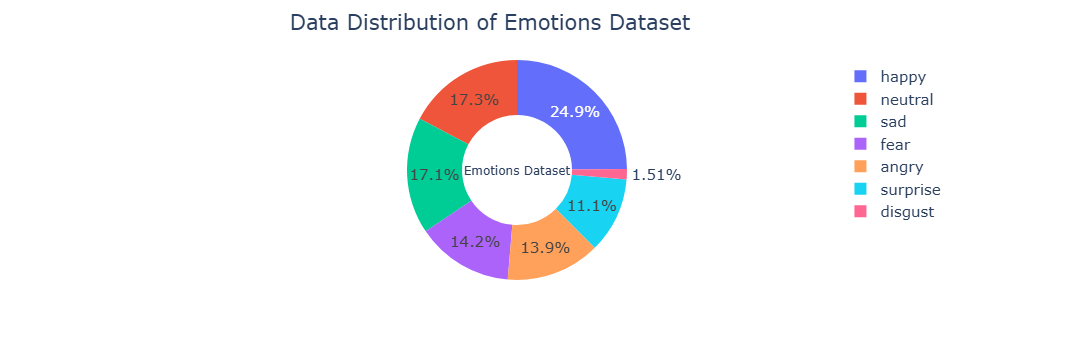

In [14]:
Class_Id_Dist_Total = df.groupby('Class')['Count'].sum().sort_values(ascending=False)
# Class_Id_Dist_Total = df['Class'].value_counts(sort=False)


import plotly.express as px
fig=px.pie(Class_Id_Dist_Total,values= Class_Id_Dist_Total.values, names=Class_Id_Dist_Total.index,hole=0.500)
fig.update_layout(title='Data Distribution of Emotions Dataset',font_size=15,title_x=0.45,annotations=[dict(text='Emotions Dataset',font_size=12, showarrow=False,height=1000,width=1000)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

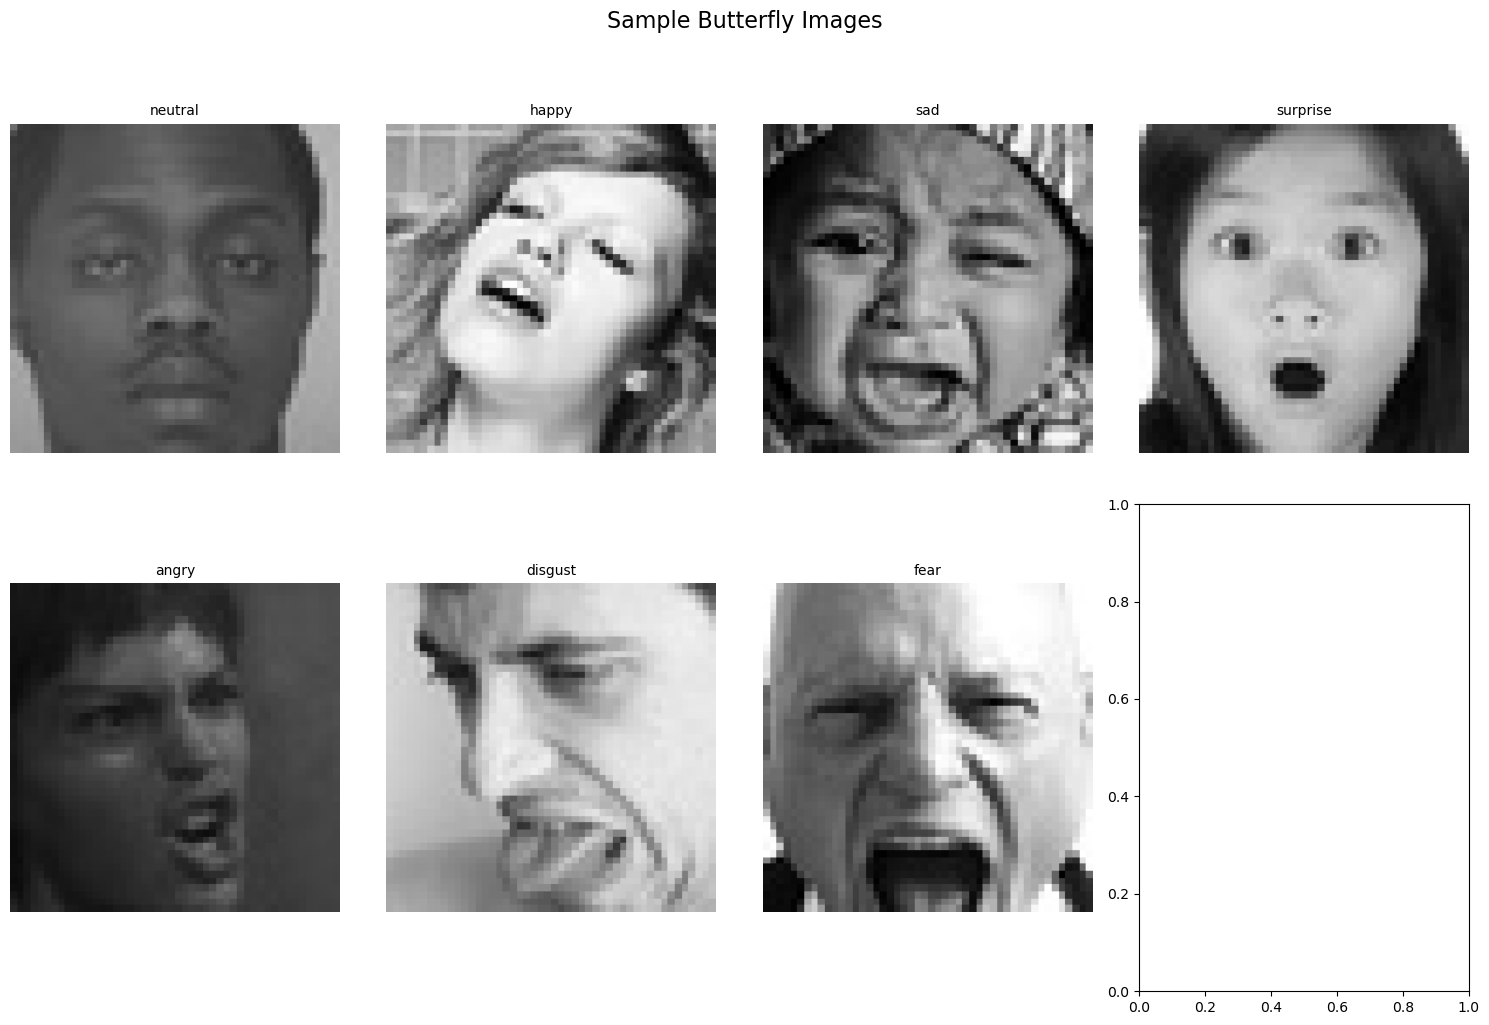

In [15]:
def plot_sample_images(directory, num_samples=12, figsize=(15, 10)):
    """Plot random sample images from the dataset."""
    classes = sorted([d.name for d in directory.iterdir() if d.is_dir()])
    selected_classes = np.random.choice(classes, min(num_samples, len(classes)), replace=False)
    
    fig, axes = plt.subplots(2, 4, figsize=figsize)
    axes = axes.ravel()
    
    for idx, class_name in enumerate(selected_classes):
        class_dir = directory / class_name
        images = list(class_dir.glob('*.jpg'))
        
        if images:
            random_image = np.random.choice(images)
            img = load_img(random_image, target_size=(IMG_HEIGHT, IMG_WIDTH))
            
            axes[idx].imshow(img)
            axes[idx].set_title(class_name, fontsize=10)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Sample Butterfly Images', fontsize=16, y=1.02)
    plt.show()

plot_sample_images(TRAIN_DIR)

In [16]:
# sns.heatmap(df, cmap='coolwarm')

In [17]:
happy_image_path = os.path.join(SAMPLE_DIR, 'happy_img.webp')

print(f"Loading image from: {happy_image_path}")

Loading image from: images\sample\happy_img.webp


Image loaded successfully!
Image format: WEBP
Image mode: RGB
Image size: (1400, 933)


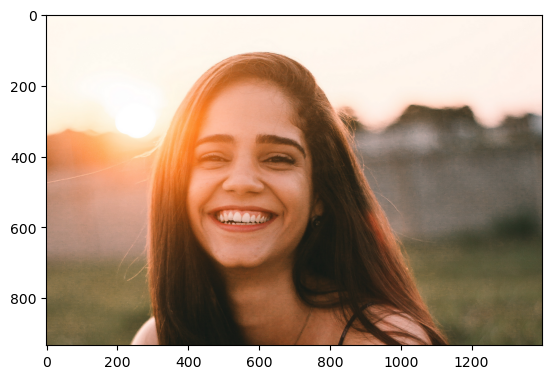

In [18]:
# Open the image using PIL
happy_image = Image.open(happy_image_path)

print(f"Image loaded successfully!")
print(f"Image format: {happy_image.format}")
print(f"Image mode: {happy_image.mode}")
print(f"Image size: {happy_image.size}")

plt.imshow(happy_image)

In [19]:
happy_array = np.array(happy_image)

red_channel = happy_array[:, :, 0]    # First channel (index 0)
green_channel = happy_array[:, :, 1]  # Second channel (index 1)
blue_channel = happy_array[:, :, 2]   # Third channel (index 2)

print(f"Red channel shape: {red_channel.shape}")
print(f"Green channel shape: {green_channel.shape}")
print(f"Blue channel shape: {blue_channel.shape}")

Red channel shape: (933, 1400)
Green channel shape: (933, 1400)
Blue channel shape: (933, 1400)


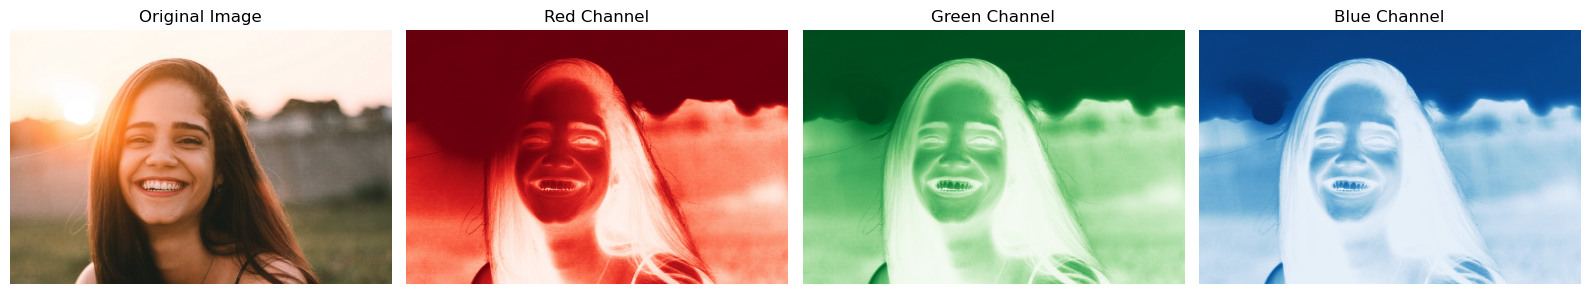

In [20]:
# Display all three channels side by side
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original image
axes[0].imshow(happy_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Red channel
axes[1].imshow(red_channel, cmap='Reds')
axes[1].set_title('Red Channel')
axes[1].axis('off')

# Green channel
axes[2].imshow(green_channel, cmap='Greens')
axes[2].set_title('Green Channel')
axes[2].axis('off')

# Blue channel
axes[3].imshow(blue_channel, cmap='Blues')
axes[3].set_title('Blue Channel')
axes[3].axis('off')

plt.tight_layout()
plt.show()


In [21]:
small_patch = happy_array[50:55, 50:55, 0]  # 5x5 patch from red channel

print("Pixel values from a 5x5 patch (Red channel):")
print(small_patch)

Pixel values from a 5x5 patch (Red channel):
[[255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]
 [255 255 255 255 255]]


## Data Preprocessing and Augmentation

In [22]:
train_data = ImageDataGenerator(
    rescale=1./255, # normalize pixel values to 0-1
    rotation_range=40, # rotating images up to 40 degress 
    width_shift_range=0.2, # randomly shifting horizontally by 20% 
    height_shift_range=0.2, # randomly shifting vertically by 20% 
    shear_range=0.2, 
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)
train_data

In [23]:
val_data = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
val_data

In [24]:
target_size = (224,224) 

In [25]:
train_gen = train_data.flow_from_directory(
    TRAIN_DIR,
    target_size=target_size,
    batch_size=32, 
    class_mode='categorical',
)


Found 28821 images belonging to 7 classes.


In [26]:
val_gen = val_data.flow_from_directory(
    VALID_DIR,
    target_size=target_size,
    batch_size=32, 
    class_mode='categorical',
    shuffle=False
)

Found 7066 images belonging to 7 classes.


In [27]:
train_gen.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [28]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, 
    restore_best_weights=True
) 

In [29]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape= (224,224,3)
)

base_model.trainable=False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(500,activation='relu'),
    Dropout(0.2),
    Dense(500,activation='relu'),
    Dropout(0.2),
    Dense(7,activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

# history = model.fit(
#     train_gen,
#     validation_data = val_gen,
#     epochs=10,
#     callbacks=[early_stopping]
# )

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │         640,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,152,491 (12.03 MB)

 Trainable params: 894,507 (3.41 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1567s 2s/step - accuracy: 0.2913 - loss: 1.7392 - val_accuracy: 0.1642 - val_loss: 2.0077
Epoch 2/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1544s 2s/step - accuracy: 0.3313 - loss: 1.6755 - val_accuracy: 0.1603 - val_loss: 1.9905
Epoch 3/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1524s 2s/step - accuracy: 0.3396 - loss: 1.6580 - val_accuracy: 0.1581 - val_loss: 2.0164
Epoch 4/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1394s 2s/step - accuracy: 0.3477 - loss: 1.6446 - val_accuracy: 0.1636 - val_loss: 1.8907
Epoch 5/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1335s 1s/step - accuracy: 0.3538 - loss: 1.6334 - val_accuracy: 0.1605 - val_loss: 2.0777
Epoch 6/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1333s 1s/step - accuracy: 0.3587 - loss: 1.6240 - val_accuracy: 0.1615 - val_loss: 1.8716
Epoch 7/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1316s 1s/step - accuracy: 0.3574 - loss: 1.6269 - val_accuracy: 0.1729 - val_loss: 1.8806
Epoch 8/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 1610s 2s/step - accuracy: 0.3591 - loss: 1.6231 - 

In [49]:
# [AI-Generated]
base_model.trainable = True

for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stopping]
)


Epoch 1/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 36271s 40s/step - accuracy: 0.3642 - loss: 1.6130 - val_accuracy: 0.1599 - val_loss: 1.8740
Epoch 2/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 1522s 2s/step - accuracy: 0.3632 - loss: 1.6116 - val_accuracy: 0.1601 - val_loss: 1.8812
Epoch 3/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 1448s 2s/step - accuracy: 0.3687 - loss: 1.6000 - val_accuracy: 0.1602 - val_loss: 1.8894
Epoch 4/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 1408s 2s/step - accuracy: 0.3657 - loss: 1.6023 - val_accuracy: 0.1606 - val_loss: 1.8914
Epoch 5/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 1406s 2s/step - accuracy: 0.3697 - loss: 1.5996 - val_accuracy: 0.1603 - val_loss: 1.8917


#### Visualisation of data augmentation

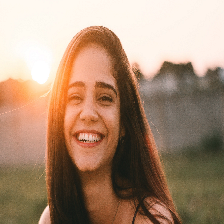

In [31]:
sample_path_img = os.path.join(SAMPLE_DIR, 'happy_img.webp')
sample_img = image.load_img(sample_path_img, target_size=target_size)
sample_img

In [32]:
arr = image.img_to_array(sample_img)
arr_img = arr.reshape((1,)+ arr.shape).shape
arr_img

(1, 224, 224, 3)

### Training curves

<Axes: >

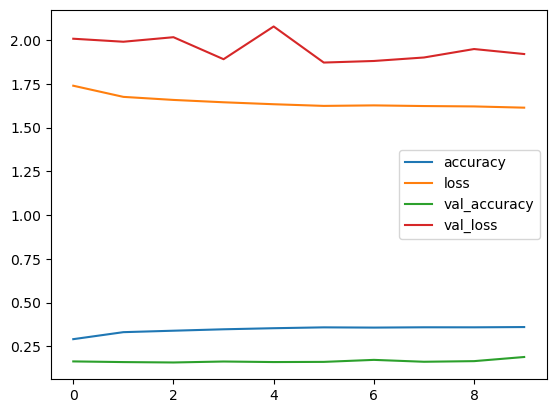

In [51]:
pd.DataFrame(history.history).plot()

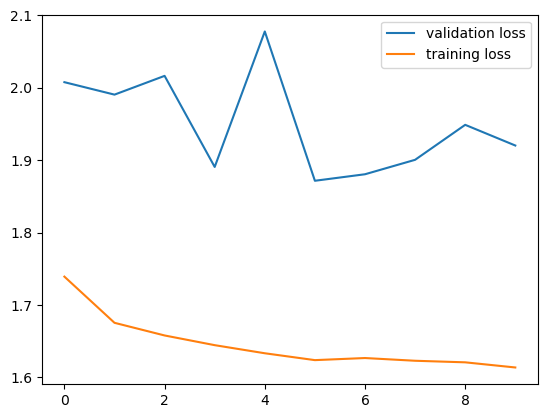

In [62]:
plt.plot(history.history['val_loss'],label='validation loss')
plt.plot(history.history['loss'],label='training loss')
plt.legend()
plt.show()

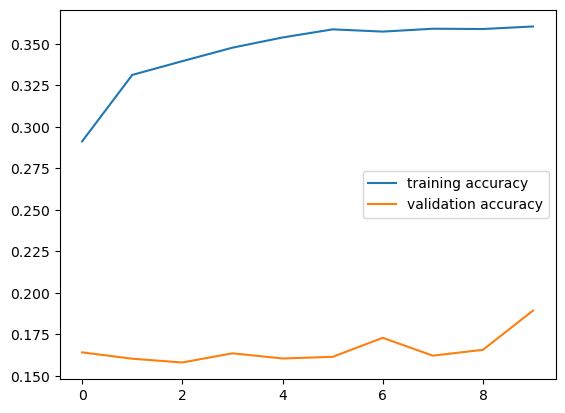

In [53]:
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend()
plt.show()

In [63]:
model.save('emotion.keras')

In [64]:
from tensorflow.keras import models
model = models.load_model('emotion.keras')

In [65]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import numpy as np

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


C:\Users\Acer\anaconda3\anaconda\envs\tensorflow_env\Lib\site-packages\PIL\Image.py:1039: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


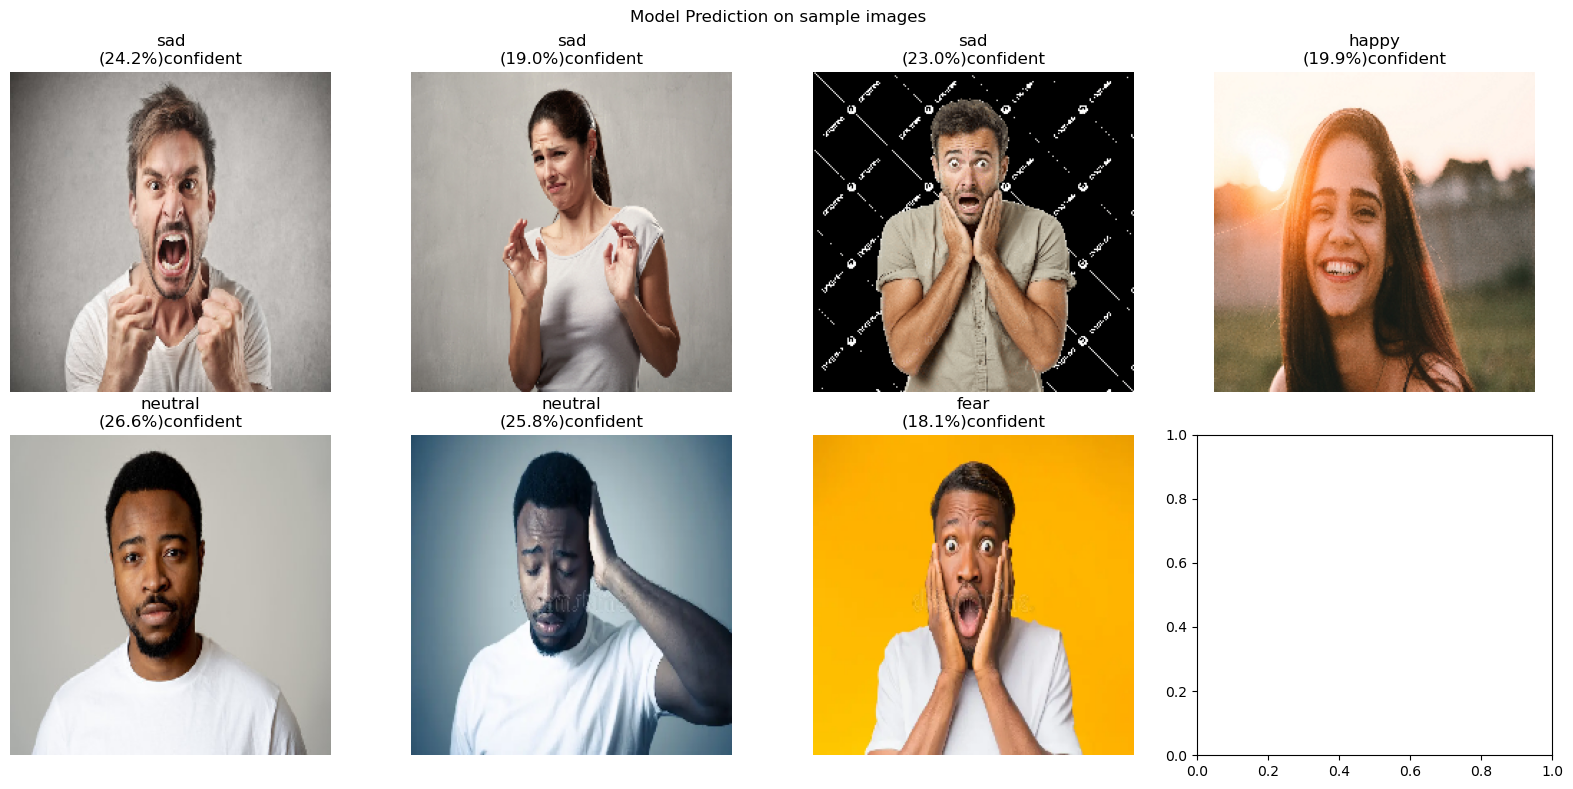

In [66]:
sample_images = [f for f in os.listdir(SAMPLE_DIR) if f.endswith(('.jpg','.jpeg','.png','.webp'))]

fig,axes = plt.subplots(2,4,figsize=(16,8))
axes = axes.flatten()

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(SAMPLE_DIR,img_name)
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array,axis=0)
    img_array = img_array/255.0

    pred  = model.predict(img_array)

    class_labels = ['angry',
 'disgust',
 'fear',
 'happy',
 'neutral',
 'sad',
 'surprise']

    # [AI-Generated]
    class_index = np.argmax(pred[0])
    conf = pred[0][class_index] * 100
    label = class_labels[class_index]

    axes[i].imshow(img)
    axes[i].set_title(f'{label}\n({conf:.1f}%)confident')
    axes[i].axis('off')
plt.suptitle('Model Prediction on sample images')
plt.tight_layout()
plt.show()

In [67]:
pred = model.predict(img_array)
print(pred)
print("Sum:", pred[0].sum())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
[[0.17725885 0.03140931 0.18099469 0.16168873 0.17036355 0.16274476
  0.11554011]]
Sum: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


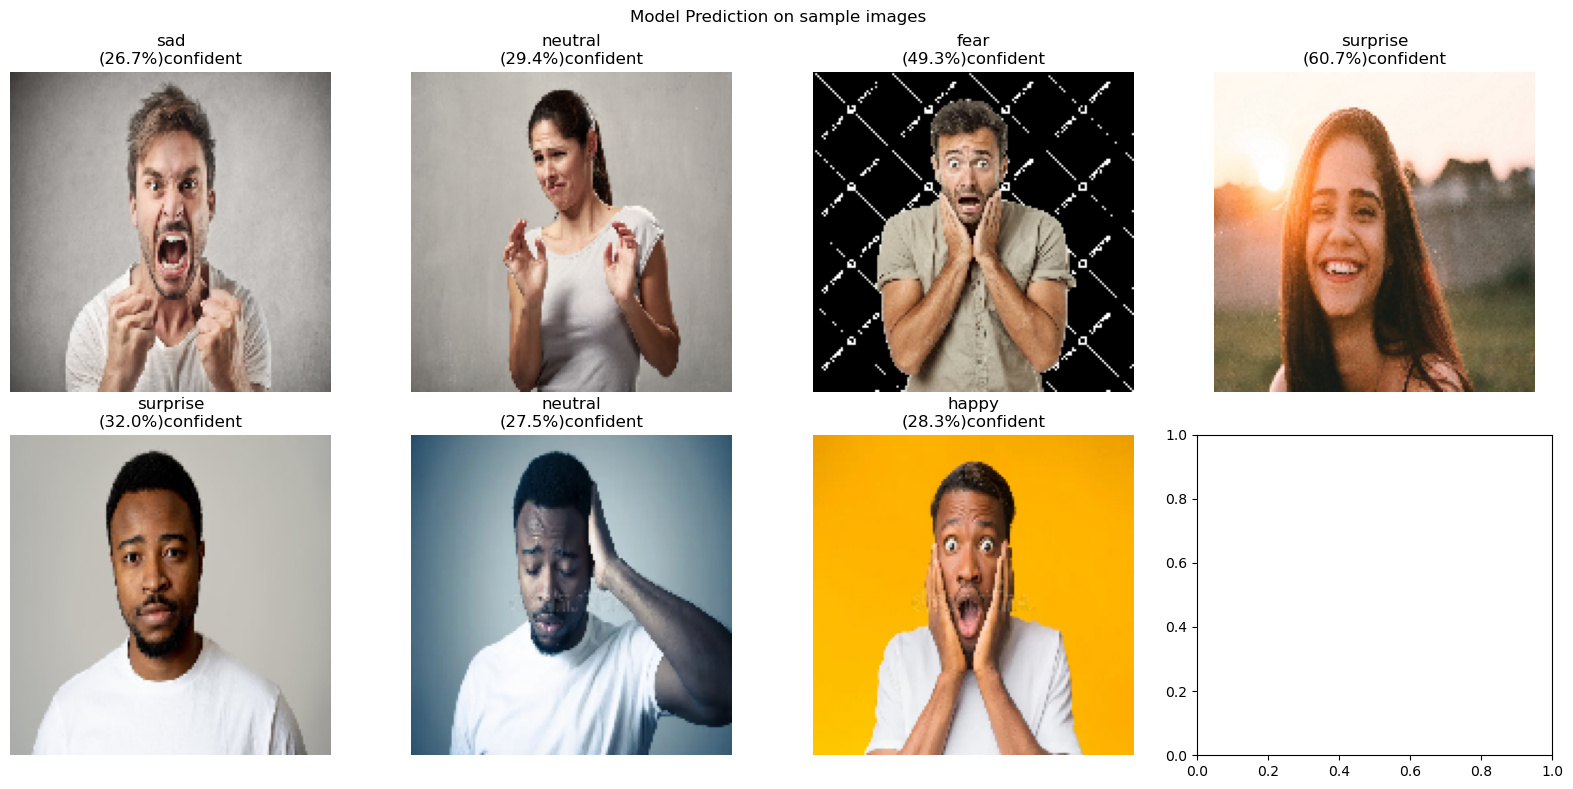

In [68]:
# map index → class name
class_labels = ['angry',
 'disgust',
 'fear',
 'happy',
 'neutral',
 'sad',
 'surprise']

sample_images = [f for f in os.listdir(SAMPLE_DIR) if f.endswith(('.jpg','.jpeg','.png','.webp'))]

fig,axes = plt.subplots(2,4,figsize=(16,8))
axes = axes.flatten()




for i, img_name in enumerate(sample_images):
    img_path = os.path.join(SAMPLE_DIR,img_name)
    img = load_img(img_path, target_size=(150,150))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array,axis=0)
    img_array = img_array/255.0

    pred  = model.predict(img_array)

    class_index = np.argmax(pred[0])
    conf = pred[0][class_index] * 100
    label = class_labels[class_index]
    
    axes[i].imshow(img)
    axes[i].set_title(f'{label}\n({conf:.1f}%)confident')
    axes[i].axis('off')
plt.suptitle('Model Prediction on sample images')
plt.tight_layout()
plt.show()

In [57]:
print(pred)

[[0.1297874  0.00235558 0.09255577 0.2832845  0.23880854 0.23734936
  0.01585887]]


In [58]:
y_pred = model.predict(val_gen)

221/221 ━━━━━━━━━━━━━━━━━━━━ 149s 656ms/step


In [71]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [70]:
y_true = val_gen.classes
y_true

array([0, 0, 0, ..., 6, 6, 6])

In [78]:
y_pred2 = np.argmax(y_pred, axis=1)

In [79]:
class_names = list(val_gen.class_indices.keys())

print("Classification Report:\n")
print(classification_report(
    y_true,
    y_pred2,
    target_names=class_names,
    digits=4
))

Classification Report:



C:\Users\Acer\anaconda3\anaconda\envs\tensorflow_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Acer\anaconda3\anaconda\envs\tensorflow_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Acer\anaconda3\anaconda\envs\tensorflow_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

       angry     0.1860    0.0083    0.0160       960
     disgust     0.0000    0.0000    0.0000       111
        fear     0.0714    0.0010    0.0019      1018
       happy     0.2157    0.0181    0.0334      1825
     neutral     0.1582    0.0255    0.0439      1216
         sad     0.1595    0.9166    0.2717      1139
    surprise     0.1140    0.0163    0.0285       797

    accuracy                         0.1599      7066
   macro avg     0.1293    0.1408    0.0565      7066
weighted avg     0.1571    0.1599    0.0656      7066



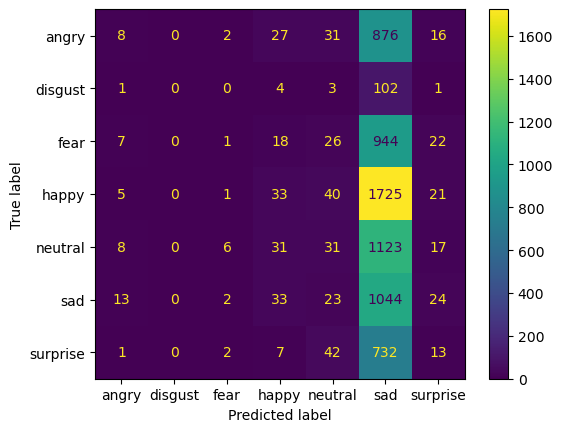

In [61]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

# y_pred: model.predict(val_gen), shape = (num_samples, 7)
pred_classes = np.argmax(y_pred, axis=1)

ConfusionMatrixDisplay.from_predictions(val_gen.classes,pred_classes,display_labels=['angry',
 'disgust',
 'fear',
 'happy',
 'neutral',
 'sad',
 'surprise'])
